In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from os.path import join
from os import getcwd
from IPython.display import clear_output

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import KFold

In [122]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.metrics import AUC # Area under the curve, default: ROC
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.optimizers.schedules import ExponentialDecay
from keras.initializers import GlorotNormal
from keras.regularizers import l1, l2

In [31]:
from functions import *

In [32]:
checkpoints_path = getcwd()+'\\checkpoints'

In [33]:
df = pd.read_csv('../../databases/diabetes.csv')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [34]:
outlayers = {
    'BloodPressure': (40, np.Inf),
    'SkinThickness': (0, 80),
    'Insulin': (0, 400),
    'BMI': (0, 50)
}

zeros = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]
x_df = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_df = df['Outcome']

In [64]:
def run_changing_state(x_dataset, y_dataset, model, state, direction, my_callbacks):
    # Split dataset into 15% test, 85% train 
    x_train, x_valid, y_train, y_valid = train_test_split(x_df, y_df, test_size=0.15, random_state=state)
    # Reemplazo los valores nulos y los outlayer
    x_train_clean, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
    x_valid_clean, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)
    # Normalizo los datasets
    x_train_norm, _norm_dict = normalize(x_train_clean, None)
    x_valid_norm, _norm_dict = normalize(x_valid_clean, _norm_dict)
    # Train model
    history_mlp_0 = mlp_model.fit(x_train_norm, y_train, validation_data=(x_valid_norm, y_valid),
                              batch_size=32, epochs=200,
                              verbose=0, callbacks=my_callbacks) 
    # Cargo el mejor modelo entrenado
    mlp_model.load_weights(direction)
    results = verify_model(mlp_model, x_train_norm, y_train, x_valid_norm, y_valid)
    return results

In [66]:
# Split dataset into 15% test, 85% train 
x_temp, x_test, y_temp, y_test = train_test_split(x_df, y_df, test_size=0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.15)

In [67]:
# Reemplazo los valores nulos y los outlayer
x_train_clean, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
x_test_clean, _data = replace_outliers_zeros(x_test, outlayers, zeros, mean_median=True, data_to_replace=_data)
x_valid_clean, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)
# Normalizo los datasets
x_train_norm, _norm_dict = normalize(x_train_clean, None)
x_valid_norm, _norm_dict = normalize(x_valid_clean, _norm_dict)
x_test_norm, _norm_dict = normalize(x_test_clean, _norm_dict)

In [68]:
stop_early = EarlyStopping(monitor='val_auc', patience=50)

### Definición de la red

In [69]:
mlp_0_checkpoint_callback = ModelCheckpoint(filepath=join(checkpoints_path, 'mlp_0'), save_weights_only=True, monitor='val_auc', mode='max', 
                                           save_best_only=True)
mlp_model = Sequential(name='mlp_0')

mlp_model.add(Dense(10, activation='relu', input_shape=(x_train_norm.shape[1],)))
mlp_model.add(Dense(5, activation='linear'))
mlp_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
mlp_model.summary()

Model: "mlp_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 6         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [70]:
mlp_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

In [71]:
history_mlp_0 = mlp_model.fit(x_train_norm, y_train, validation_data=(x_valid_norm, y_valid),
                              batch_size=32, epochs=200,
                              verbose=1, callbacks=[mlp_0_checkpoint_callback]) 

Epoch 1/200
18/18 [==============================] - 1s 58ms/step - loss: 0.7705 - auc: 0.7599 - val_loss: 0.6159 - val_auc: 0.7702
Epoch 2/200
18/18 [==============================] - 0s 16ms/step - loss: 0.5413 - auc: 0.8417 - val_loss: 0.5418 - val_auc: 0.7830
Epoch 3/200
18/18 [==============================] - 0s 10ms/step - loss: 0.4856 - auc: 0.8529 - val_loss: 0.5331 - val_auc: 0.7924
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4670 - auc: 0.8573 - val_loss: 0.5731 - val_auc: 0.7780
Epoch 5/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4805 - auc: 0.8454 - val_loss: 0.5519 - val_auc: 0.7820
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4615 - auc: 0.8608 - val_loss: 0.5442 - val_auc: 0.7833
Epoch 7/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4559 - auc: 0.8640 - val_loss: 0.5429 - val_auc: 0.7778
Epoch 8/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4484 

In [72]:
# Cargo el mejor modelo entrenado
mlp_model.load_weights(join(checkpoints_path, 'mlp_0'))
verify_model(mlp_model, x_train_norm, y_train, x_valid_norm, y_valid)

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.858927,0.887006,0.660000,0.767442,0.821990
1,Validacion,0.792906,0.760563,0.592593,0.484848,0.830769


Salieron resultados interesantes, vamos a verificar si se mantiene al cambiar el random state al hacer split de los datos

In [73]:
mlp_state = Sequential(name='mlp_1')
mlp_state.add(Dense(10, activation='relu', input_shape=(x_train_norm.shape[1],)))
mlp_state.add(Dense(5, activation='linear'))
mlp_state.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
mlp_state.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
pesos_inicial = mlp_state.get_weights()
mlp_state.summary()

Model: "mlp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 6         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [74]:
train_auc = []
valid_auc = []
results = []

for i in range(10):
    print('Runing state', i)
    name  = 'mlp_state_{}'.format(i)
    mlp_state.set_weights(pesos_inicial)
    checkdir = join(checkpoints_path, name)
    temp_callback = ModelCheckpoint(filepath=checkdir, save_weights_only=True, monitor='val_auc', mode='max', save_best_only=True)
    metrics = run_changing_state(x_temp, y_temp, mlp_state, i, checkdir, [temp_callback])
    results.append(metrics)
    train_auc.append(metrics['AUC ROC'][0])
    valid_auc.append(metrics['AUC ROC'][1])
    

Runing state 0
Runing state 1
Runing state 2
Runing state 3
Runing state 4
Runing state 5
Runing state 6
Runing state 7
Runing state 8
Runing state 9


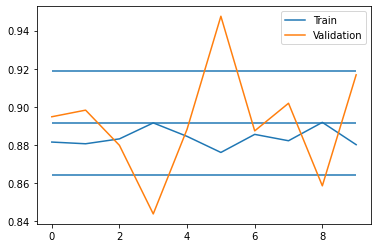

In [75]:
plt.plot(train_auc, label='Train')
plt.plot(valid_auc, label='Validation')
mean = np.mean(valid_auc)
std = np.std(valid_auc)
plt.hlines([mean+std, mean, mean-std], 0, 9)   
plt.legend()
plt.show()

Se puede observar que en la mayoria de los casos la metrica de validación da mejor que la metrica de train, con lo cual se puede inferir que el modelo tendrá una gran varianza debido a la poca cantidad de datos disponible para los parámetros que requiere entrenar el modelo. Por lo tanto una mejor opcion es utilizar k-folding en lugar de hold out validation

Ahora vamos a probar utilizar 1 o 2 capas ocultas, variando la cantidad de neuronas entre 5, 10 y 30, modificando la activacion entre relu y lineal. Para ello utilizaremos la tecnica de k-folding y la metrica de cada set de hyperparámetros sera el promedio de las metricas de cada fold. Una vez testeado esto se continuara buscando mejorar el modelo cambiando la regularizacion o agregando capas de Droput o Batch Normalization

In [86]:
folding = KFold(n_splits=5)

def train_model(x_dataset, y_dataset, model, name, batch, stopping_patiece=None):
    pesos_default = model.get_weights()
    folds = folding.split(x_dataset)
    auc_val = []
    results = []
    curr = 0
    for train, valid in folds:
        # Split dataset
        x_train, x_valid = x_dataset.iloc[train], x_dataset.iloc[valid]
        y_train, y_valid = y_dataset.iloc[train], y_dataset.iloc[valid]
        
        # Proceso los datos
        x_train_c, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
        x_valid_c, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)
        # Normalizo los datasets
        x_train_n, _norm_dict = normalize(x_train_c, None)
        x_valid_n, _norm_dict = normalize(x_valid_c, _norm_dict)
    
        # Create callbacks
        checkdir = join(checkpoints_path, name+'f{}'.format(curr))
        temp_callback = ModelCheckpoint(filepath=checkdir, save_weights_only=True, monitor='val_auc', mode='max', save_best_only=True)
        my_callbacks = [temp_callback]
        if stopping_patiece:
            my_callbacks.append(EarlyStopping(monitor='val_auc', patience=stopping_patiece))
        # Train model
        history = model.fit(x_train_n, y_train, validation_data=(x_valid_n, y_valid),
                            batch_size=batch, epochs=200,
                            verbose=0, callbacks=my_callbacks) 
        # Cargo el mejor modelo entrenado
        model.load_weights(checkdir)
        metrics = verify_model(model, x_train_n, y_train, x_valid_n, y_valid)
        auc_val.append(metrics['AUC ROC'][1])
        results.append(metrics)
        # Reset model for next training
        model.set_weights(pesos_default)
    return np.mean(auc_val), results    

1 capa

In [87]:
results = {}

for neuronas in [5, 10, 30]:
    for activation in ['linear', 'relu']:
        for batch in [32, 64]:
            name = 'n{}_b{}_{}'.format(neuronas, batch, activation)
            print('Testing ->', name)
            # Armo el modelo
            test_model = Sequential(name=name)
            test_model.add(Dense(neuronas, activation=activation, input_shape=(x_temp.shape[1],)))
            test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
            # Compilo el modelo
            test_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
            auc, metrics = train_model(x_temp, y_temp, test_model, name, batch, stopping_patiece=50)
            results[name] = (auc, metrics)
            print('Auc score = ', auc)

Testing -> n5_b32_linear
Auc score =  0.8465187586075779
Testing -> n5_b64_linear
Auc score =  0.8435372247737304
Testing -> n5_b32_relu
Auc score =  0.8512925704116805
Testing -> n5_b64_relu
Auc score =  0.8348620106520915
Testing -> n10_b32_linear
Auc score =  0.8442330867064156
Testing -> n10_b64_linear
Auc score =  0.8419770482188458
Testing -> n10_b32_relu
Auc score =  0.8519265572777279
Testing -> n10_b64_relu
Auc score =  0.8515506365062905
Testing -> n30_b32_linear
Auc score =  0.8443438546762918
Testing -> n30_b64_linear
Auc score =  0.8454345812591655
Testing -> n30_b32_relu
Auc score =  0.855564919677362
Testing -> n30_b64_relu
Auc score =  0.85330703757104


In [88]:
for neuronas_1 in [5, 10, 30]:
    for neuronas_2 in [5, 10, 30]:
        for activation in ['linear', 'relu']:
            for batch in [32, 64]:
                name = 'na{}_nb{}_b{}_{}'.format(neuronas_1, neuronas_2, batch, activation)
                print('Testing ->', name)
                # Armo el modelo
                test_model = Sequential(name=name)
                test_model.add(Dense(neuronas_1, activation=activation, input_shape=(x_temp.shape[1],)))
                test_model.add(Dense(neuronas_2, activation=activation))
                test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
                # Compilo el modelo
                test_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
                auc, metrics = train_model(x_temp, y_temp, test_model, name, batch, stopping_patiece=50)
                results[name] = (auc, metrics)

Testing -> na5_nb5_b32_linear
Testing -> na5_nb5_b64_linear
Testing -> na5_nb5_b32_relu
Testing -> na5_nb5_b64_relu
Testing -> na5_nb10_b32_linear
Testing -> na5_nb10_b64_linear
Testing -> na5_nb10_b32_relu
Testing -> na5_nb10_b64_relu
Testing -> na5_nb30_b32_linear
Testing -> na5_nb30_b64_linear
Testing -> na5_nb30_b32_relu
Testing -> na5_nb30_b64_relu
Testing -> na10_nb5_b32_linear
Testing -> na10_nb5_b64_linear
Testing -> na10_nb5_b32_relu
Testing -> na10_nb5_b64_relu
Testing -> na10_nb10_b32_linear
Testing -> na10_nb10_b64_linear
Testing -> na10_nb10_b32_relu
Testing -> na10_nb10_b64_relu
Testing -> na10_nb30_b32_linear
Testing -> na10_nb30_b64_linear
Testing -> na10_nb30_b32_relu
Testing -> na10_nb30_b64_relu
Testing -> na30_nb5_b32_linear
Testing -> na30_nb5_b64_linear
Testing -> na30_nb5_b32_relu
Testing -> na30_nb5_b64_relu
Testing -> na30_nb10_b32_linear
Testing -> na30_nb10_b64_linear
Testing -> na30_nb10_b32_relu
Testing -> na30_nb10_b64_relu
Testing -> na30_nb30_b32_linear


Veo los 10 mejores resultados

In [103]:
sorted_results = list(reversed(sorted(results.items(), key=lambda x: x[1][0])))
for i in sorted_results[0:10]:
    print(i[0], '->', i[1][0])


na30_nb30_b64_relu -> 0.861352840215399
na30_nb10_b32_relu -> 0.8582115959904792
na30_nb10_b64_relu -> 0.8566529766960528
n30_b32_relu -> 0.855564919677362
na30_nb30_b32_relu -> 0.8551248583486846
na30_nb5_b64_relu -> 0.8539013062773699
n30_b64_relu -> 0.85330703757104
na10_nb30_b32_relu -> 0.8531993851794029
na10_nb5_b32_relu -> 0.8529004140800847
na10_nb10_b32_relu -> 0.8521677479696826


Se puede observar como los de mejor performance son en su mayoria redes con 2 capas ocultas, y con gran cantidad de neuronas en cada una. Con estos resultados se buscara optimizar los hyperparámetros de los 3 mejores

In [109]:
results_2 = {}
neurona_1 = 30
for neurona_2 in [10, 30]:
    for act_n1 in ['relu', 'linear']:
        for act_n2 in ['relu', 'linear']:
            for batch in [32, 64]:
                for drop in [0, 1]:
                    name = 'na{}_nb{}_b{}_{}_{}_d{}'.format(neurona_1, neurona_2, batch, act_n1, act_n2, drop)
                    print('Testing ->', name)
                    # Armo el modelo
                    test_model = Sequential(name=name)

                    test_model.add(Dense(neurona_1, activation=act_n1, input_shape=(x_temp.shape[1],)))
                    if drop:
                        test_model.add(Dropout(rate=0.2))
                    test_model.add(Dense(neurona_2, activation=act_n2))

                    test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
                    # Compilo el modelo
                    test_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
                    auc, metrics = train_model(x_temp, y_temp, test_model, name, batch, stopping_patiece=50)
                    results_2[name] = (auc, metrics)
                
sorted_results_2 = list(reversed(sorted(results_2.items(), key=lambda x: x[1][0])))
for i in sorted_results_2[0:10]:
    print(i[0], '->', i[1][0])

Testing -> na30_nb10_b32_relu_relu_d0
Testing -> na30_nb10_b32_relu_relu_d1
Testing -> na30_nb10_b64_relu_relu_d0
Testing -> na30_nb10_b64_relu_relu_d1
Testing -> na30_nb10_b32_relu_linear_d0
Testing -> na30_nb10_b32_relu_linear_d1
Testing -> na30_nb10_b64_relu_linear_d0
Testing -> na30_nb10_b64_relu_linear_d1
Testing -> na30_nb10_b32_linear_relu_d0
Testing -> na30_nb10_b32_linear_relu_d1
Testing -> na30_nb10_b64_linear_relu_d0
Testing -> na30_nb10_b64_linear_relu_d1
Testing -> na30_nb10_b32_linear_linear_d0
Testing -> na30_nb10_b32_linear_linear_d1
Testing -> na30_nb10_b64_linear_linear_d0
Testing -> na30_nb10_b64_linear_linear_d1
Testing -> na30_nb30_b32_relu_relu_d0
Testing -> na30_nb30_b32_relu_relu_d1
Testing -> na30_nb30_b64_relu_relu_d0
Testing -> na30_nb30_b64_relu_relu_d1
Testing -> na30_nb30_b32_relu_linear_d0
Testing -> na30_nb30_b32_relu_linear_d1
Testing -> na30_nb30_b64_relu_linear_d0
Testing -> na30_nb30_b64_relu_linear_d1
Testing -> na30_nb30_b32_linear_relu_d0
Testing 

In [123]:
results_3 = {}
redes = [[30, 10, 64, 'relu', 'linear'],
         [30, 30, 32, 'linear', 'relu']]

for n1, n2, b, a1, a2 in redes:
    for drop in [0, 1]:
        name = 'na{}_nb{}_b{}_{}_{}_d{}_b'.format(n1, n2, b, a1, a2, drop)
        print('Testing ->', name)
        # Armo el modelo
        test_model = Sequential(name=name)

        test_model.add(Dense(n1, activation=a1, input_shape=(x_temp.shape[1],)))
        
        test_model.add(Dense(n2, activation=a2))
        
        if drop:
            test_model.add(Dropout(rate=0.5))
        else:
            test_model.add(BatchNormalization())
            
        test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
        # Compilo el modelo
        test_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
        auc, metrics = train_model(x_temp, y_temp, test_model, name, b, stopping_patiece=50)
        results_3[name] = (auc, metrics)
        clear_output(wait=True)
                
sorted_results_3 = list(reversed(sorted(results_3.items(), key=lambda x: x[1][0])))
for i in sorted_results_3:
    print(i[0], '->', i[1][0])

na30_nb30_b32_linear_relu_d0_b -> 0.8597472460015325
na30_nb30_b32_linear_relu_d1_b -> 0.8597348839580329
na30_nb10_b64_relu_linear_d1_b -> 0.8570038988289698
na30_nb10_b64_relu_linear_d0_b -> 0.85498259413843


Finalmente no se pudieron conseguir mejoras sustanciales agregando capas de Droput o BatchNormalization

#### Optimizando hypperparametros del optimizador y regularizacion

In [125]:
results_4 = {}
redes = [[30, 10, 64, 'relu', 'linear'],
         [30, 30, 32, 'linear', 'relu']]

for i in [0, 1]:
    n1, n2, b, a1, a2 = redes[i]
    for lr in [5e-3, 0.01, 0.02, 0.05, 0.1, 0.5]:
        for l_2 in [0.01, 0.05, 0.1, 0.25, 0.5]:
            name = 'red{}_lr{}_l2{}_'.format(i, lr, l_2)
            print('Testing ->', name)
            # Armo el modelo
            test_model = Sequential(name=name)

            test_model.add(Dense(n1, activation=a1, input_shape=(x_temp.shape[1],)))

            test_model.add(Dense(n2, activation=a2))

            test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l_2)))
            # Compilo el modelo
            test_model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
            auc, metrics = train_model(x_temp, y_temp, test_model, name, b, stopping_patiece=50)
            results_4[name] = (auc, metrics)
            clear_output(wait=True)
                
sorted_results_4 = list(reversed(sorted(results_4.items(), key=lambda x: x[1][0])))
for i in sorted_results_4[:10]:
    print(i[0], '->', i[1][0])

red0_lr0.1_l20.01_ -> 0.8626701657288848
red1_lr0.02_l20.25_ -> 0.8625874450119826
red0_lr0.05_l20.01_ -> 0.8620204559421782
red0_lr0.02_l20.05_ -> 0.8617906318241826
red1_lr0.02_l20.1_ -> 0.8609841614011632
red1_lr0.02_l20.05_ -> 0.8609068547063339
red0_lr0.1_l20.5_ -> 0.8608401046760982
red1_lr0.05_l20.25_ -> 0.8602072845659061
red0_lr0.05_l20.1_ -> 0.8598520700543266
red0_lr0.01_l20.25_ -> 0.8594192145576507
